<a href="https://colab.research.google.com/github/turneyj37/turneyj37/blob/main/GalaxyCA_refined.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Step 1 - Outlining the Initial Parameters

For this simulation I am going to be using a salpeter IMF:

$\xi(M) = \xi_0 (\dfrac{M}{M_{sun}})^{-2.35}$

This probability density function follows a power law that is accurate for any mass equal to 0.5 solar masses or higher.

Given that the upper mass limit for star formation is thought to be 150 solar masses, I will operate between these 2 limits.

$0.5M_{sun} < M < 150M_{sun}$

For this piece of work, I will also use the following parameters:

- The total initial mass of the gas cloud = $10^{11}M_{sun}$
- Star formation rate (SFR) only occurs for the first 1 billion years and uses all the mass
- Therefore, star formation rate = $\dfrac{10^{11}}{10^9}$ = $100 M_{sun} yr^{-1}$ = $\psi_0$
- Stars only contribute to the galaxies number count, mass and luminosity during the main sequence of their life time and their gas mass is not recycled.

In [ ]:
### IMPORT PACKAGES ###

import numpy as np
import matplotlib.pyplot as plt
import scipy.optimize as sp
import astropy.modeling.models as ap
import pandas as pd
from scipy.integrate import quad

### OUTLINE PARAMETERS ###

M_gas = 10**11
SFR = 100

# Step 2 - Calculating Xi Zero

In the equation for the IMF, there is a constant that is determined by the stellar density and acts as a scaling factor for all subsequent calculations.

Given that I know the SFR and upper mass limit, I can work out the total mass formed in the first instance of the galaxies existence and work out the constant, Xi zero, from there.

$\tau_{ms} = 10Gyr(\dfrac{M}{M_{sun}})^{-2.5}$

If I sub in the upper limit for mass here, I can work out the most amount of time that could elapse and have no stellar deaths during. This means that the total mass is given by:

$M_{tot} = SFR*\tau_gal$

where,

$\tau_{ms}(150M_{sun}) = \tau_{gal}$

In [ ]:
def lifetime(M):
  return (10**10)*((M)**(-2.5))

print('The main sequence life time of a 150 solar mass star is {:.3} years'.format(lifetime(150)))

The main sequence life time of a 150 solar mass star is 3.63e+04 years


By subbing this into the equation for total mass, I can then calculate Xi zero.

$M_{tot} = \int_{0.5M_{sun}}^{150M_{sun}} N(M) M dM$

where N(M) is simply the IMF multiplied by the star formation rate and elapsed time.

$N(M) = \psi_0 \tau_{ms} \xi (M)$

Therefore, the total mass can be re-written as:

$M_{tot} = \int_{0.5M_{sun}}^{150M_{sun}} \psi_0 \tau_{ms} \xi (M) M dM = \psi_0 \tau_{ms} \xi_0 \int_{0.5M_{sun}}^{150M_{sun}} \left( \dfrac{M}{M_{sun}} \right)^{-2.35}M = \psi_0 \tau_{ms} \xi_0 M_{sun} \int_{0.5}^{150} M^{-1.35}$

In the final line I have prematurely taken out solar mass unit that would stem from multiplying by the mass. 

$M_{tot} = \psi_0 \tau_{ms} = \psi_0 \tau_{ms} \xi_0 M_{sun} \int_{0.5}^{150} M^{-1.35}$

The time and SFR can cancel out.

$1 = \xi_0 M_{sun} \int_{0.5}^{150} M^{-1.35} = \dfrac{\xi_0 M_{sun}}{0.35}(0.5^{-0.35}-150^{-0.35})$

In [ ]:
RHS = ((0.5**(-0.35))-(150**(-0.35)))/0.35

print('The right hand side equals {:.4} xi zero solar masses'.format(RHS))

The right hand side equals 3.147 xi zero solar masses


$\xi_0 M_{sun} = \dfrac{1}{3.147}$

In [ ]:
xi = 1/3.147

print('The value of xi zero is {:.3} solar masses'.format(xi))

The value of xi zero is 0.318 solar masses


# Step 3 - Defining the Eras

The simplest way to model this galaxy will be to model the 2 time periods separately and merge them together. The 2 time periods are:

1) The first billion years - The star formation period.

2) The remaining 11 billion years - The period of no star formation.

To model, I will calcualte the total luminosity of the galaxy at set intervals. The time period selected must be less than or equal to the shortest life span of any given star. This was given earlier in calculating the lifetime of the 150 solar mass star.

$\Delta \tau = \tau_{ms}(150) < 3.63 * 10^{4} yrs = 2*10^{-4} yrs$

I chose this number so it would fit evenly into the 12 billion year life time of the galaxy.

In [ ]:
time_stamps = []

for i in range (0,12*10**9,2*10**4):
  time_stamps.append(i)

print('This gives a total of {:.0f} data points'.format(len(time_stamps)))

This gives a total of 600000 data points


## The Star Formation Period and Critical Mass

During this time the calculations are a little bit more complicated at each time stamp as there are stars dying and being born.

To account for this, I can use 2 separate power laws relating to a critical mass. The critical mass is the oldest largest possible mass to have been born given the galaxies age at each time stamp. It is calculated by subbing in the galaxies age in to the main sequence life time and finding M.

$M_{crit} = \sqrt[-2.5]{\dfrac{\tau_{gal}}{10^{10}}}M_{sun}$

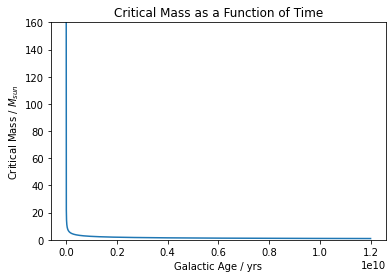

In [ ]:
Mc = []

def critical_mass(tau):
  return (tau/(10**10))**(-1/2.5)

for i in time_stamps:
  if i > 0:
    Mc.append(critical_mass(i))

plt.plot(time_stamps[1:],Mc)
plt.ylim(0,160)
plt.xlabel('Galactic Age / yrs')
plt.ylabel('Critical Mass / $M_{sun}$')
plt.title("Critical Mass as a Function of Time")
plt.show()

In [ ]:
print(critical_mass(2*10**9))

1.9036539387158786


The graph above shows just how short lived massive stars are. This means that once the star formation period has ended, I will expect to see high mass stars die off rapidly.

What this means in terms of calculating the luminosity is that there are 2 power laws in calculating the contribution.

Those above the critical mass are far more likely to have died so follow a stepper curve.

1) Above the critical mass: $M > M_{crit}$

$N(M) = \psi_0 \xi_0 10Gyr (M)^{-4.85}$

2) Below the critical mass: $M < M_{crit}$

$N(M) = \psi_0 \xi_0 \tau_{gal} (M)^{-2.35}$

Below the critical mass the power law is unchanged from the IMF as not enough time has elapsed for these initial stars to die off and disappear. 


## The Luminosity Functions

The luminosity of a star follows a power law depending on the mass range in question. They all follow the following formula:

$L(M) = L_{sun} \left( \dfrac{M}{M_{sun}} \right)^{\alpha}$

Where alpha varies with the mass range in question.

- $\alpha = 5$ for $M < 1M_{sun}$
- $\alpha = 3.9$ for $1M_{sun} < M < 10M_{sun}$
- $\alpha = 3.5$ for $M > 10M_{sun}$

These power laws suggests that truly massive stars will dominate the luminosity profile.

# Step 4 - Plotting the Luminosity Function for the First Billion Years

Now to piece together all the initial parameters and conditions. The overall Luminosity is given by:

$L_{gal} = \int_{0.5}^{150} L_{tot}(M) N(M) dM$

This equation will have to be broken up into 3 separate integrals depending on the luminosity power law.

$L_{gal} = \left( \int_{0.5}^{1} M^{5} N(M) dM \right)+ \left( \int_{1}^{10} M^{3.9} N(M) dM \right) + \left( \int_{10}^{150} M^{3.5} N(M) dM \right) = \xi_0 \psi_0 \tau{gal} \left[ \left( \int_{0.5}^{1} M^{5} M^{-2.35} dM \right)+ \left( \int_{1}^{10} M^{3.9} M^{-2.35} dM \right) + \left( \int_{10}^{150} M^{3.5} M^{-2.35} dM \right)  \right]$

This will be further broken up depending on the critical mass at each given time as $N(M) \propto M^{-4.85}$ when above the critical mass.

To begin I will first define all the possible prifiles of luminosity and critical mass combined:

In [ ]:
def lum_low_below(M,a,b):
  return (M**(5))*a*b*(M**(-2.35))

def lum_low_above(M,a,b):
  return (M**(5))*a*b*(M**(-4.85))

def lum_med_below(M,a,b):
  return (M**(3.9))*a*b*(M**(-2.35))

def lum_med_above(M,a,b):
  return (M**(3.9))*a*b*(M**(-4.85))

def lum_high_below(M,a,b):
  return (M**(3.5))*a*b*(M**(-2.35))

def lum_high_above(M,a,b):
  return (M**(3.5))*a*b*(M**(-4.85))


In [ ]:
# Now to set up every time stamp as the age of the gal at that time.

L=[0]

for i in range(0,len(time_stamps)):
  if time_stamps[i] > 0 and time_stamps[i] <=10**9:
    tau_gal = time_stamps[i]
    M_crit = critical_mass(tau_gal)

    if M_crit > 10:
      L1 = tau_gal*quad(lum_low_below,0.5,1,args=(xi,SFR))[0]  
      L2 = tau_gal*quad(lum_med_below,1,10,args=(xi,SFR))[0]
      L3 = tau_gal*quad(lum_high_below,10,M_crit,args=(xi,SFR))[0]
      L4 = (10**10)*quad(lum_high_above,M_crit,150,args=(xi,SFR))[0]

      L.append(L1+L2+L3+L4)

    elif M_crit > 1:
      L1 = tau_gal*quad(lum_low_below,0.5,1,args=(xi,SFR))[0]  
      L2 = tau_gal*quad(lum_med_below,1,M_crit,args=(xi,SFR))[0]
      L3 = (10**10)*quad(lum_med_above,M_crit,10,args=(xi,SFR))[0]
      L4 = (10**10)*quad(lum_high_above,10,150,args=(xi,SFR))[0]

      L.append(L1+L2+L3+L4)

    else:
      L1 = tau_gal*quad(lum_low_below,0.5,M_crit,args=(xi,SFR))[0]  
      L2 = (10**10)*quad(lum_low_above,M_crit,1,args=(xi,SFR))[0]
      L3 = (10**10)*quad(lum_med_above,1,10,args=(xi,SFR))[0]
      L4 = (10**10)*quad(lum_high_above,10,150,args=(xi,SFR))[0]

      L.append(L1+L2+L3+L4)    


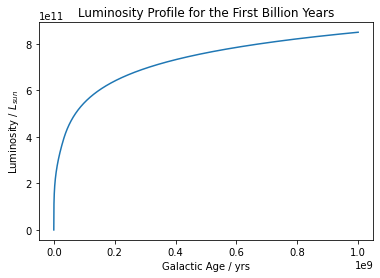

In [ ]:
plt.plot(time_stamps[0:50001],L)
plt.xlabel('Galactic Age / yrs')
plt.ylabel('Luminosity / $L_{sun}$')
plt.title('Luminosity Profile for the First Billion Years')
plt.show()

# Step 5 - Calculating the Post Star Formation Luminosity

To work out the post star forming luminosity is a little tricky. The luminosity will begin to drop but it must take into account the state of the galaxy at the moment star formation ended. At the moment star formation halts, stars only begin to die.

At $\tau = 10^9 yrs$:

We have a critical mass of 2.51 solar masses. If we now exclude the star formation rate at this time and use the following equation to work out the luminosity:

$L = \xi_0 \left[ \int^{M_{crit}}_{0.5}M^{\alpha}M^{-2.35} \right]+\left[ \int^{150}_{M_{crit}}M^{\alpha}M^{-4.85} \right] $

Given that we know the total luminosity at this time, we can work a new value for xi, which will scale all values in the post star forming era, accounting for the prior conditions.



In [ ]:
print('The value for luminosity at 1 billion years is {:.3} solar luminosities'.format(L[-1]))
print('The value for critical mass at 1 billion years is {:.3} solar masses'.format(critical_mass(10**9)))

The value for luminosity at 1 billion years is 8.5e+11 solar luminosities
The value for critical mass at 1 billion years is 2.51 solar masses


I will have to work out the integrals for the 3 values of alpha and then split the medium range integral in 2, due to the critical mass limit. If i divide the total luminosity by the sum of these luminosities, I will get my new xi value.


In [ ]:
M_crit = 2.51

# I changed the arguemnets to equal 1 rahter than write out new definitions

I1 = quad(lum_low_below,0.5,1,args=(1,1))[0]  
I2 = quad(lum_med_below,1,M_crit,args=(1,1))[0]
I3 = quad(lum_med_above,M_crit,10,args=(1,1))[0]
I4 = quad(lum_high_above,10,150,args=(1,1))[0]

I = I1 + I2 + I3 + I4
L_ref = L[-1]

print('The sum of these integrals is {:.3}'.format(I))

xi_new = L_ref/I

print('The new value for xi is {:.3}'.format(xi_new))

The sum of these integrals is 6.24
The new value for xi is 1.36e+11


With new profile constant, I can work out the remaining values of Luminosity.

In [ ]:
def lum_low_below(M,a):
  return (M**(5))*a*(M**(-2.35))

def lum_low_above(M,a):
  return (M**(5))*a*(M**(-4.85))

def lum_med_below(M,a):
  return (M**(3.9))*a*(M**(-2.35))

def lum_med_above(M,a):
  return (M**(3.9))*a*(M**(-4.85))

def lum_high_below(M,a):
  return (M**(3.5))*a*(M**(-2.35))

def lum_high_above(M,a):
  return (M**(3.5))*a*(M**(-4.85))

# I can remove b as I am no only concerned with the value of xi
# SFR contributes nothing.

xi = xi_new

for i in range(0,len(time_stamps)):
  if time_stamps[i] > 10**9:
    tau_gal = time_stamps[i]
    M_crit = critical_mass(tau_gal)

    if M_crit > 10:
      L1 = quad(lum_low_below,0.5,1,args=(xi))[0]  
      L2 = quad(lum_med_below,1,10,args=(xi))[0]
      L3 = quad(lum_high_below,10,M_crit,args=(xi))[0]
      L4 = quad(lum_high_above,M_crit,150,args=(xi))[0]

      L.append(L1+L2+L3+L4)

    elif M_crit > 1:
      L1 = quad(lum_low_below,0.5,1,args=(xi))[0]  
      L2 = quad(lum_med_below,1,M_crit,args=(xi))[0]
      L3 = quad(lum_med_above,M_crit,10,args=(xi))[0]
      L4 = quad(lum_high_above,10,150,args=(xi))[0]

      L.append(L1+L2+L3+L4)

    else:
      L1 = quad(lum_low_below,0.5,M_crit,args=(xi))[0]  
      L2 = quad(lum_low_above,M_crit,1,args=(xi))[0]
      L3 = quad(lum_med_above,1,10,args=(xi))[0]
      L4 = quad(lum_high_above,10,150,args=(xi))[0]

      L.append(L1+L2+L3+L4)



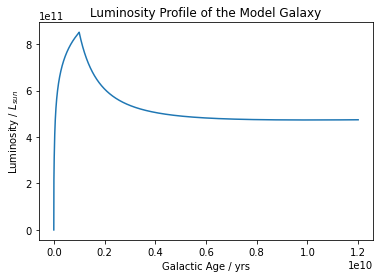

In [ ]:
plt.plot(time_stamps,L)
plt.xlabel('Galactic Age / yrs')
plt.ylabel('Luminosity / $L_{sun}$')
plt.title('Luminosity Profile of the Model Galaxy')
plt.show()

# Step 6 - Absolute V Magnitude of the Galaxy



Given that:

$Mv_{star} = -2.5log(\dfrac{L_{star}}{L_{sun}}) + Mv_{sun}$

and that:

$L \propto M^{\alpha}$

It stands to reason that:

$Mv_{star} = -2.5log(M_{star}^{\alpha}) + Mv_{sun} = -2.5 \alpha log(M) + Mv_{sun}$

Using this logic and the data provided, I can find the approximated values for the constants.

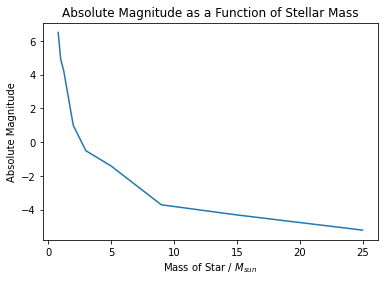

[-3.384909    4.50469491]


In [ ]:
mass = [0.8,1.0,1.25,2.0,3.0,5.0,9.0,15.0,25.0]
Mv = [6.5,4.93,4.2,1.0,-0.5,-1.4,-3.7,-4.3,-5.2]

plt.plot(mass,Mv)
plt.xlabel('Mass of Star / $M_{sun}$')
plt.ylabel('Absolute Magnitude')
plt.title('Absolute Magnitude as a Function of Stellar Mass')
plt.show()

import scipy.optimize as sp

def Mag(x,a,b):
  return a*np.log(x) + b

optgal, covgal = sp.curve_fit(Mag, mass, Mv)

print(optgal)


From the curve fit I can assume the following relationship:

$Mv = -3.385log(M) + 4.505$

Now that I have the absolute magnitude in terms of mass, I can multiply it by the IMF and integrate over all value of M to find the total absolute magnitude at any given time.

An assumption I will be making here is that the value for alpha does not change anymore. It holds true across the entire function for all values of M. 

## The Magnitude of the First Billion years

In [ ]:
def mag_low_below(M,a,b):
  return (-3.385*np.log(M)+4.505)*a*b*(M**(-2.35))

def mag_low_above(M,a,b):
  return (-3.385*np.log(M)+4.505)*a*b*(M**(-4.85))

def mag_med_below(M,a,b):
  return (-3.385*np.log(M)+4.505)*a*b*(M**(-2.35))

def mag_med_above(M,a,b):
  return (-3.385*np.log(M)+4.505)*a*b*(M**(-4.85))

def mag_high_below(M,a,b):
  return (-3.385*np.log(M)+4.505)*a*b*(M**(-2.35))

def mag_high_above(M,a,b):
  return (-3.385*np.log(M)+4.505)*a*b*(M**(-4.85))

xi = 1/3.147
SFR = 100

Mv_gal=[0]

for i in range(0,len(time_stamps)):
  if time_stamps[i] > 0 and time_stamps[i] <=10**9:
    tau_gal = time_stamps[i]
    M_crit = critical_mass(tau_gal)

    if M_crit > 10:
      L1 = tau_gal*quad(mag_low_below,0.5,1,args=(xi,SFR))[0]  
      L2 = tau_gal*quad(mag_med_below,1,10,args=(xi,SFR))[0]
      L3 = tau_gal*quad(mag_high_below,10,M_crit,args=(xi,SFR))[0]
      L4 = (10**10)*quad(mag_high_above,M_crit,150,args=(xi,SFR))[0]

      Mv_gal.append(L1+L2+L3+L4)

    elif M_crit > 1:
      L1 = tau_gal*quad(mag_low_below,0.5,1,args=(xi,SFR))[0]  
      L2 = tau_gal*quad(mag_med_below,1,M_crit,args=(xi,SFR))[0]
      L3 = (10**10)*quad(mag_med_above,M_crit,10,args=(xi,SFR))[0]
      L4 = (10**10)*quad(mag_high_above,10,150,args=(xi,SFR))[0]

      Mv_gal.append(L1+L2+L3+L4)

    else:
      L1 = tau_gal*quad(mag_low_below,0.5,M_crit,args=(xi,SFR))[0]  
      L2 = (10**10)*quad(mag_low_above,M_crit,1,args=(xi,SFR))[0]
      L3 = (10**10)*quad(mag_med_above,1,10,args=(xi,SFR))[0]
      L4 = (10**10)*quad(mag_high_above,10,150,args=(xi,SFR))[0]

      Mv_gal.append(L1+L2+L3+L4)  



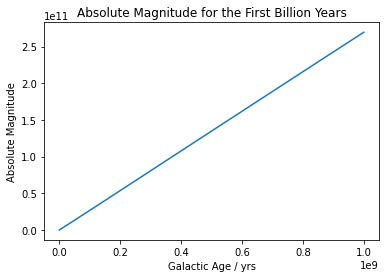

In [ ]:
plt.plot(time_stamps[0:50001],Mv_gal)
plt.xlabel('Galactic Age / yrs')
plt.ylabel('Absolute Magnitude')
plt.title('Absolute Magnitude for the First Billion Years')
plt.show()